# Case Study 3 - Multiple Runs

This notebook uses the ```seaborn```, which is not listed as a requirement for this library. Therefore, make sure to install it before running this notebook. To install it, use the following:

```console
> pip install seaborn
```

This notebook, as in **case3.ipynb**, we will explore the **thyroid disease** dataset. Similar to **case1_stat.ipynb/case2_stat.ipynb**, we will run the same experiment multiple times in order to see if a preprocessing step improves the model's performance with statistical significance.

## 0 - Defining Basic Functionalities

In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database
from matplotlib.pyplot import figure

import raimitigations.dataprocessing as dp
import case_study_utils as cs

N_EXEC = 50

USE_AUC_TH = False

In [2]:
def encode_case3(df):
    enc_ohe = dp.EncoderOHE(verbose=False)
    enc_ohe.fit(df)
    proc_df = enc_ohe.transform(df)
    return proc_df


# -----------------------------------
def encode_case3_train_test(train_x, test_x):
    enc_ohe = dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)
    enc_ohe.fit(train_x)
    train_x_enc = enc_ohe.transform(train_x)
    test_x_enc = enc_ohe.transform(test_x)
    return train_x_enc, test_x_enc


# -----------------------------------
def impute_case3(df):
    imputer = dp.BasicImputer(	numerical={	'missing_values':np.nan,
                                            'strategy':'constant',
                                            'fill_value':-1},
                                verbose=False)
    imputer.fit(df)
    proc_df = imputer.transform(df)
    return proc_df


# -----------------------------------
def impute_case3_train_test(train_x, test_x):
    imputer = dp.BasicImputer(	numerical={	'missing_values':np.nan,
                                            'strategy':'constant',
                                            'fill_value':-1},
                                verbose=False)
    imputer.fit(train_x)
    train_x_enc = imputer.transform(train_x)
    test_x_enc = imputer.transform(test_x)
    return train_x_enc, test_x_enc

In [3]:
def test_base(df, label_col, n_exec, model_name):
    result_list = []
    proc_df = encode_case3(df)
    proc_df = impute_case3(proc_df)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
        result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat


# -----------------------------------
def test_corr(df, label_col, n_exec, model_name):
    result_list = []
    proc_df = cs.remove_corr_feat(df, label_col)
    proc_df = encode_case3(proc_df)
    proc_df = impute_case3(proc_df)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
        result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat


# -----------------------------------
def test_corr_transf(df, label_col, n_exec, scaler_ref, model_name, num_col=None):
    result_list = []
    proc_df = cs.remove_corr_feat(df, label_col)
    proc_df = encode_case3(proc_df)
    proc_df = impute_case3(proc_df)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
        train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
        result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat

# -----------------------------------
def test_smote_transf(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, under=False):
    result_list = []
    proc_df = df
    if rcorr:
        proc_df = cs.remove_corr_feat(proc_df, label_col)
    proc_df = encode_case3(proc_df)
    proc_df = impute_case3(proc_df)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
        if art_str is not None:
            train_x, train_y = cs.artificial_smote(train_x, train_y, art_str, under)
        if feat_sel_type is not None:
            train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
        if scaler_ref is not None:
            train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
        result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat



# -----------------------------------
def test_ctgan_first(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, savefile=None):
    result_list = []
    proc_df = df
    if rcorr:
        proc_df = cs.remove_corr_feat(proc_df, label_col)
    for n in range(n_exec):
        train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
        if art_str is not None:
            train_x, train_y = cs.artificial_ctgan(train_x, train_y, art_str, savefile, epochs=1000)
        train_x, test_x = encode_case3_train_test(train_x, test_x)
        train_x, test_x = impute_case3_train_test(train_x, test_x)
        if feat_sel_type is not None:
            train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
        if scaler_ref is not None:
            train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
        result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
        result_list.append(result)

    result_stat = cs.result_statistics(result_list)

    return result_stat

## 1 - Understanding the Data

In [4]:
df = database.load_thyroid_disease()
label_col = "sick-euthyroid"
df[label_col] = df[label_col].replace({"sick-euthyroid": 1, "negative": 0})
df

,sick-euthyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,1,72.0,M,f,f,f,f,f,f,f,...,y,1.0,y,83.0,y,0.95,y,87.0,n,NaN
1,1,45.0,F,f,f,f,f,f,f,f,...,y,1.0,y,82.0,y,0.73,y,112.0,n,NaN
2,1,64.0,F,f,f,f,f,f,f,f,...,y,1.0,y,101.0,y,0.82,y,123.0,n,NaN
3,1,56.0,M,f,f,f,f,f,f,f,...,y,0.8,y,76.0,y,0.77,y,99.0,n,NaN
4,1,78.0,F,t,f,f,f,t,f,f,...,y,0.3,y,87.0,y,0.95,y,91.0,n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,0,40.0,F,f,f,f,f,f,f,f,...,y,1.2,y,76.0,y,0.90,y,84.0,n,NaN
3159,0,69.0,F,f,f,f,f,f,f,f,...,y,1.8,y,126.0,y,1.02,y,124.0,n,NaN
3160,0,58.0,F,f,f,f,f,f,f,f,...,y,1.7,y,86.0,y,0.91,y,95.0,n,NaN
3161,0,29.0,F,f,f,f,f,f,f,f,...,y,1.8,y,99.0,y,1.01,y,98.0,n,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sick-euthyroid             3163 non-null   int64  
 1   age                        2717 non-null   float64
 2   sex                        3090 non-null   object 
 3   on_thyroxine               3163 non-null   object 
 4   query_on_thyroxine         3163 non-null   object 
 5   on_antithyroid_medication  3163 non-null   object 
 6   thyroid_surgery            3163 non-null   object 
 7   query_hypothyroid          3163 non-null   object 
 8   query_hyperthyroid         3163 non-null   object 
 9   pregnant                   3163 non-null   object 
 10  sick                       3163 non-null   object 
 11  tumor                      3163 non-null   object 
 12  lithium                    3163 non-null   object 
 13  goitre                     3163 non-null   objec

In [6]:
num_col = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

## 2 - Efficiency of Different Classes from raimitigations.dataprocessing lib

### KNN Model

#### Data Transformations

Here we compare 8 different training pipelines with a KNN model. For each pipeline, 50 runs are performed, and the mean and stdev of the metrics are computed and plotted in the graph below.

- baseline dataset
- baseline dataset, removal of correlated features
- baseline dataset, removal of correlated features, standard scaler
- baseline dataset, removal of correlated features, minmax scaler
- baseline dataset, removal of correlated features, quantile transformer
- baseline dataset, removal of correlated features, data normalizer
- baseline dataset, removal of correlated features, robust scaler
- baseline dataset, removal of correlated features, power transformer

Note: Some of the experiments below take 10+ min to run. You may change `N_EXEC` to a smaller number to decrease the time it takes to run the notebook.

In [7]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(result_df, result_cor, "Corr.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataMinMaxScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Min/Max.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Quantile")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataNormalizer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Normalizer")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataPowerTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Power")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

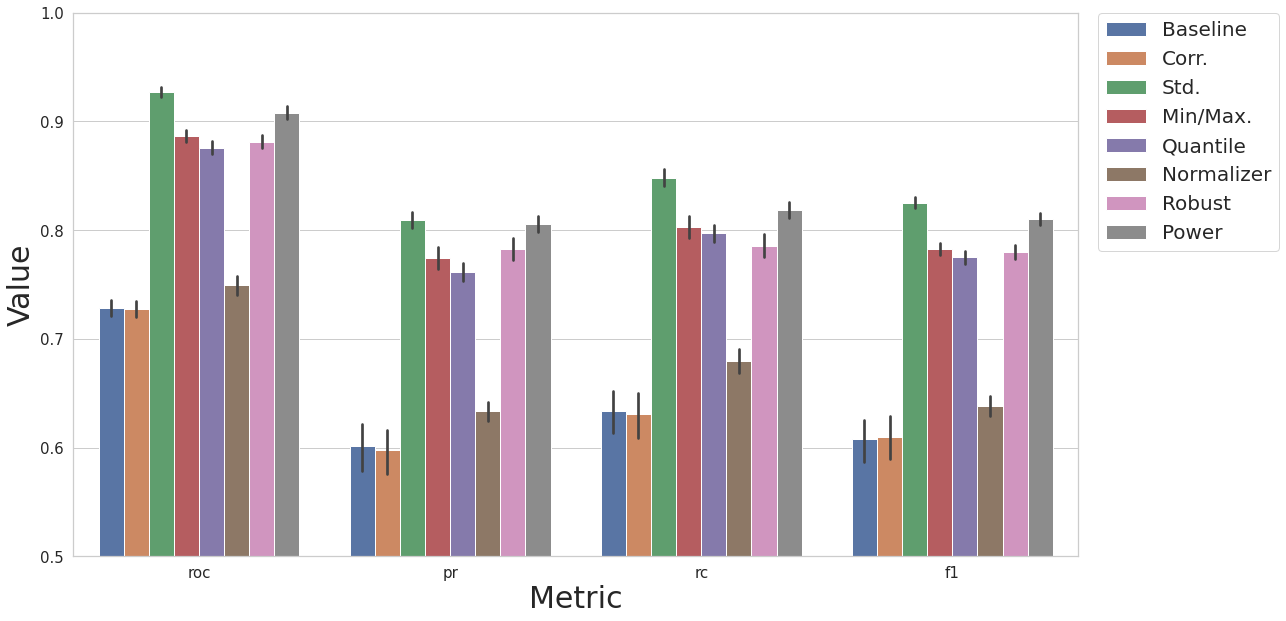

In [10]:
cs.plot_results(result_df, y_lim=[0.5, 1.0])

The standard scaler performs best here, and we will use it as a baseline in the following experiments.

#### Sequential Feature Selection - Forward

Now we will perform feature selection, where all features are first removed from the dataset, and then re-added to see if they improve the model performance. We will compare three different feature selection pipelines with two baseline models.

- Baseline KNN model
- KNN model with standard scaler scaler and correlated features removed
- KNN model, sequential feature selection
- KNN model, removal of correlated features, sequential feature selection
- KNN model, standard scaler, removal of correlated features, sequential feature selection

In [11]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=None, feat_sel_type='forward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq. Fwd.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type='forward')
result_df = cs.add_results_df(result_df, restult_fs, "Corr.Seq.Fwd")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, num_col=num_col, feat_sel_type='forward')
result_df = cs.add_results_df(result_df, restult_fs, "Corr.Seq.Fwd.Std.")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

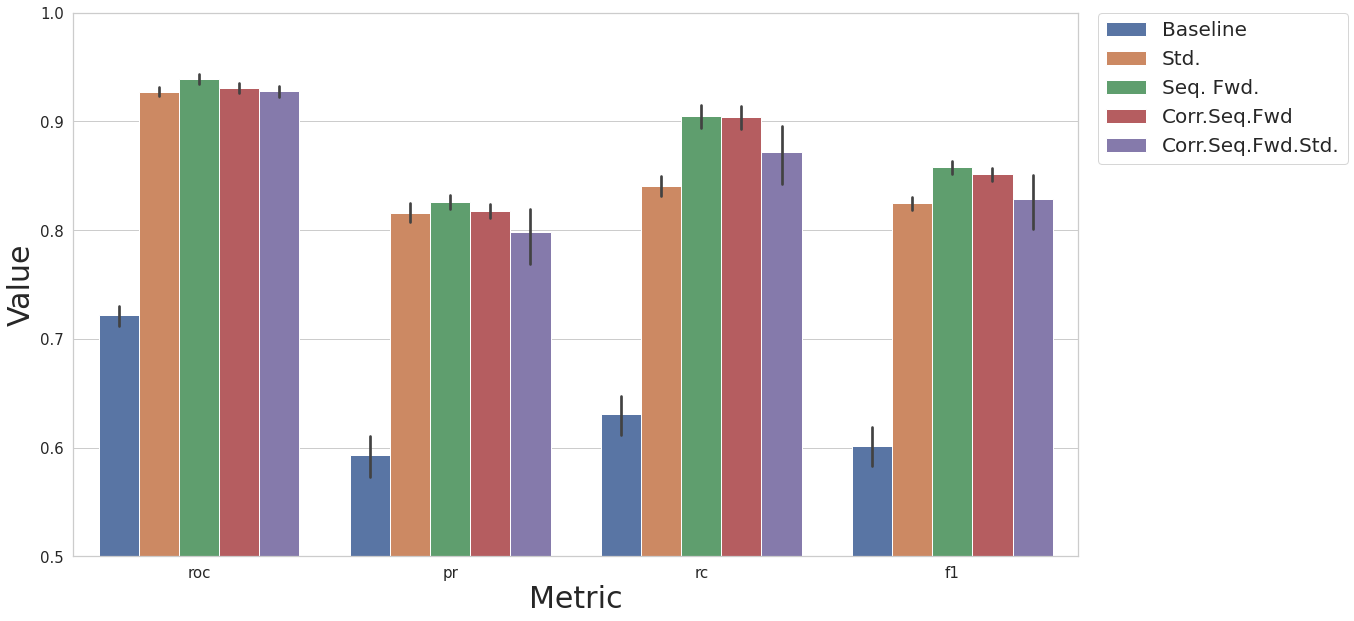

In [12]:
cs.plot_results(result_df, y_lim=[0.5, 1.0])

#### Sequential Feature Selection - Forward x Backward x CatBoost Feature Selection

We now compare forward and backward feature selection. We then add in the standard scaler, and compare with CatBoost.

- Baseline KNN model
- KNN model, forward sequential feature selection
- KNN model, backward sequential feature selection
- KNN model, standard scaler, backward sequential feature selection
- KNN model, standard scaler, catboost feature selection

In [13]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=None, feat_sel_type='forward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq. Fwd.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=None, feat_sel_type='backward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq. Bwd.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=dp.DataStandardScaler, num_col=num_col, feat_sel_type='backward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq.Bwd.Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=dp.DataStandardScaler, num_col=num_col, feat_sel_type='catboost')
result_df = cs.add_results_df(result_df, restult_fs, "CatBoost Std.")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

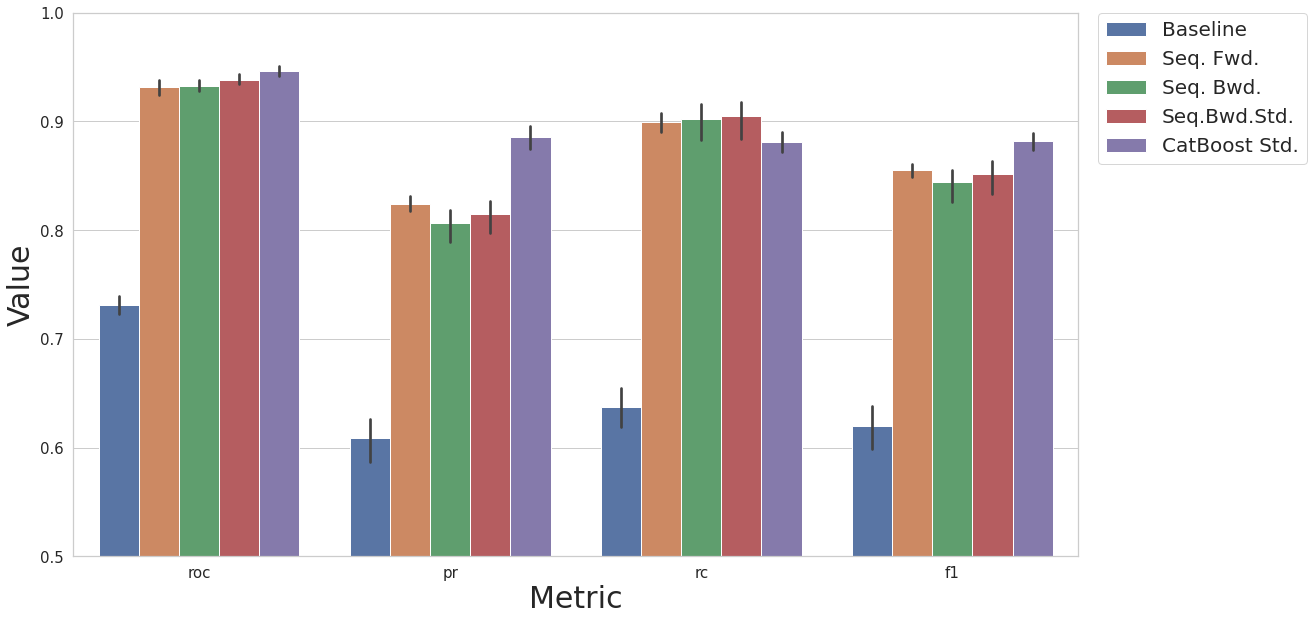

In [14]:
cs.plot_results(result_df, y_lim=[0.5, 1.0])

#### Artificial Instances - SMOTE

We generate artificial instances for the minority class.

- baseline KNN model
- baseline KNN model with standard scaler and removal of correlated features
- KNN model, remove correlated features, SMOTE artificial data
- KNN model, remove correlated features, standard scaler, SMOTE artificial data
- KNN model, remove correlated features, SMOTE artificial data, TomekLink under sampling
- KNN model, remove correlated features, standard scaler, SMOTE artificial data, TomekLink under sampling

In [15]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.2, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.2, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM Std.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.2, under=True)
result_df = cs.add_results_df(result_df, restult_fs, "SM+TK")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.2, under=True)
result_df = cs.add_results_df(result_df, restult_fs, "SM+TK Std.")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

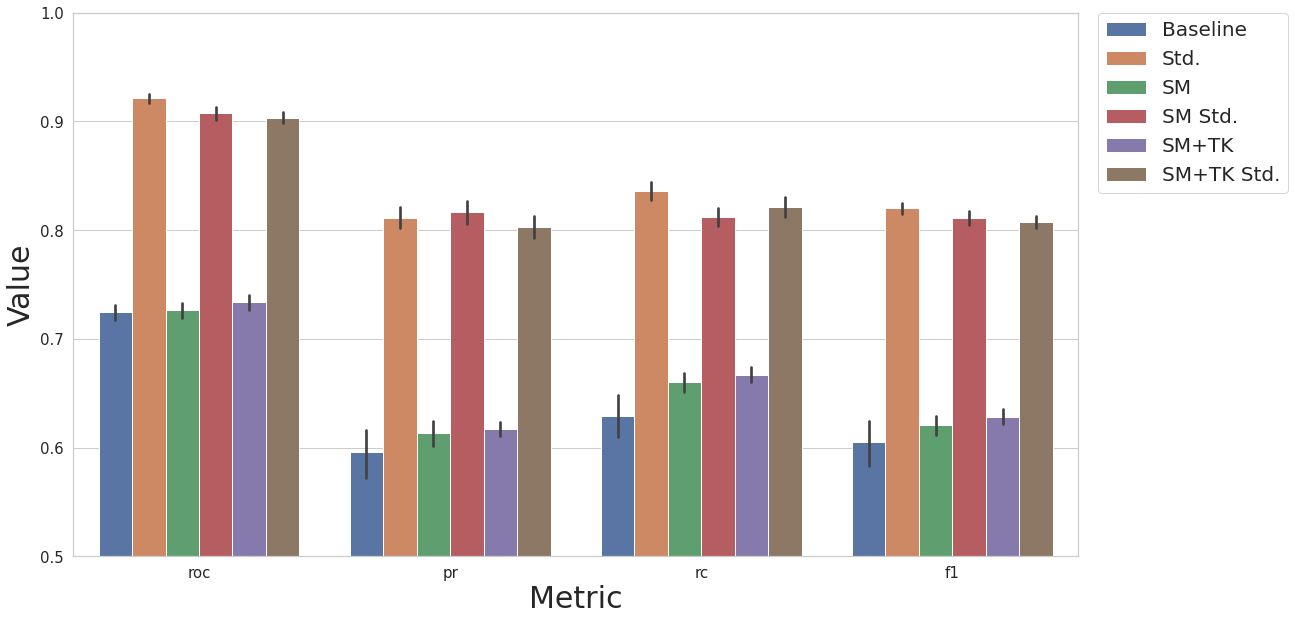

In [16]:
cs.plot_results(result_df, y_lim=[0.5, 1.0])

With this dataset, the standard scaler and feature selection improves the model. But the artificial instances generated here do not improve the model.

#### Artificial Instances - CTGAN

Next, we attempt to improve the model with CTGAN generated instances.

- KNN baseline model
- baseline KNN model with standard scaler and removal of correlated features
- KNN model, standard scaler, removal of correlated features, over sampling with CTGAN ratio of 0.2
- KNN model, standard scaler, removal of correlated features, over sampling with CTGAN ratio of 0.6

In [17]:
MODEL_NAME = "knn"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.2, savefile="3_1.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.2 Std.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataStandardScaler, feat_sel_type=None, art_str=0.6, savefile="3_2.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.6 Std.")


/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

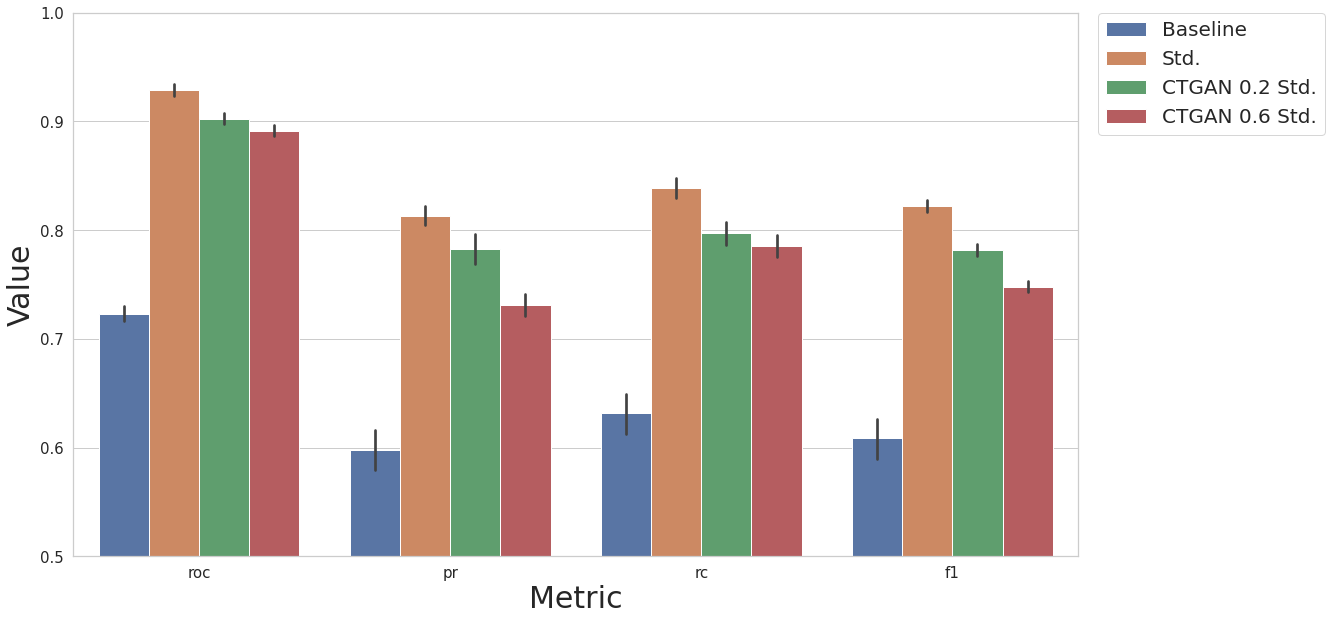

In [18]:
cs.plot_results(result_df, y_lim=[0.5, 1.0])

Again, adding the artificial instances does not improve the model.

### XGBoost

The above experiments were performed with a KNN model. Below, we perform the same experiments with an XGBoost model to see how it affects model performance.

In [19]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(result_df, result_cor, "Corr.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataMinMaxScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Min/Max.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Quantile")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataNormalizer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Normalizer")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataPowerTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Power")

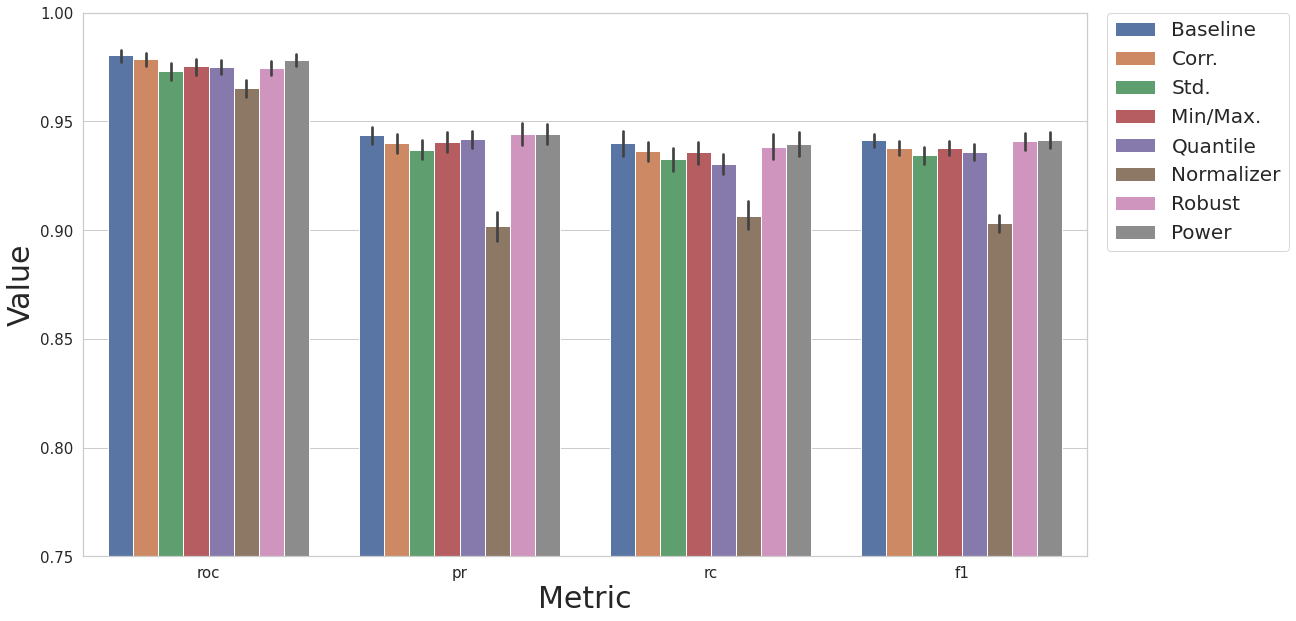

In [20]:
cs.plot_results(result_df, y_lim=[0.75,1.0])

In [21]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type='backward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq.Bwd.Qtl.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type='catboost')
result_df = cs.add_results_df(result_df, restult_fs, "CatBoost Qtl.")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


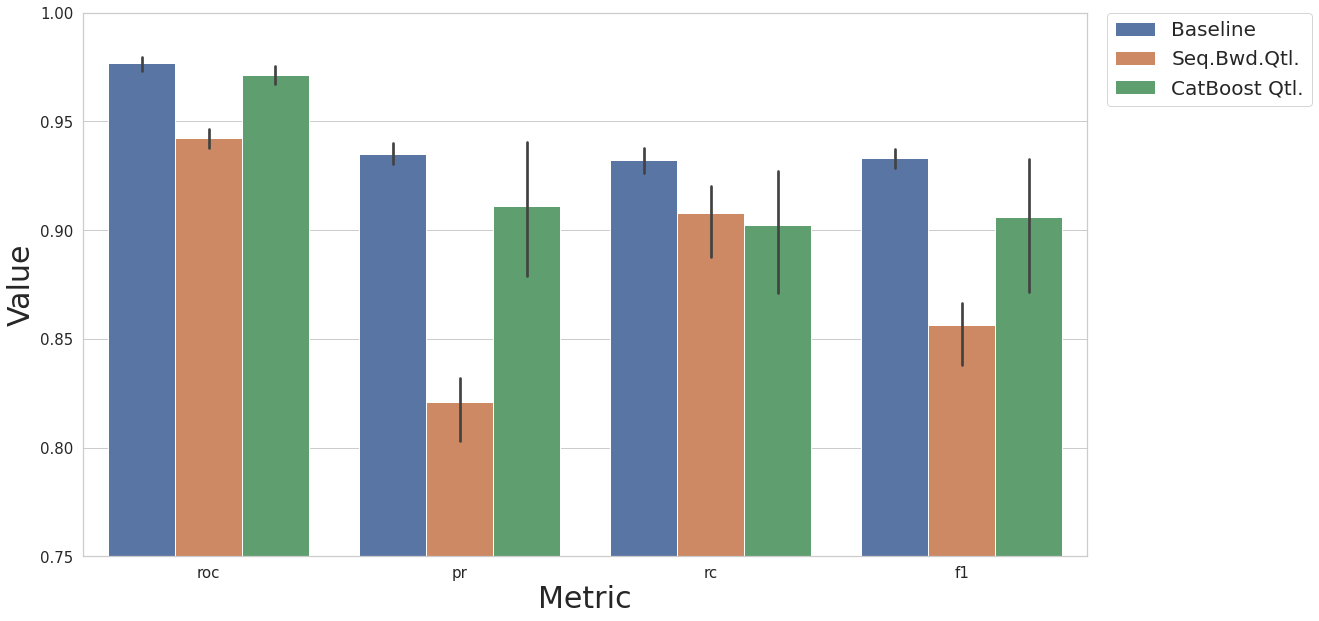

In [22]:
cs.plot_results(result_df, y_lim=[0.75,1.0])

In [23]:
MODEL_NAME = "xgb"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Qtl.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type=None, art_str=0.2, savefile="3_3.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.2 Qtl.")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataQuantileTransformer, num_col=num_col, feat_sel_type=None, art_str=0.6, savefile="3_4.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.6 Qtl.")


/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


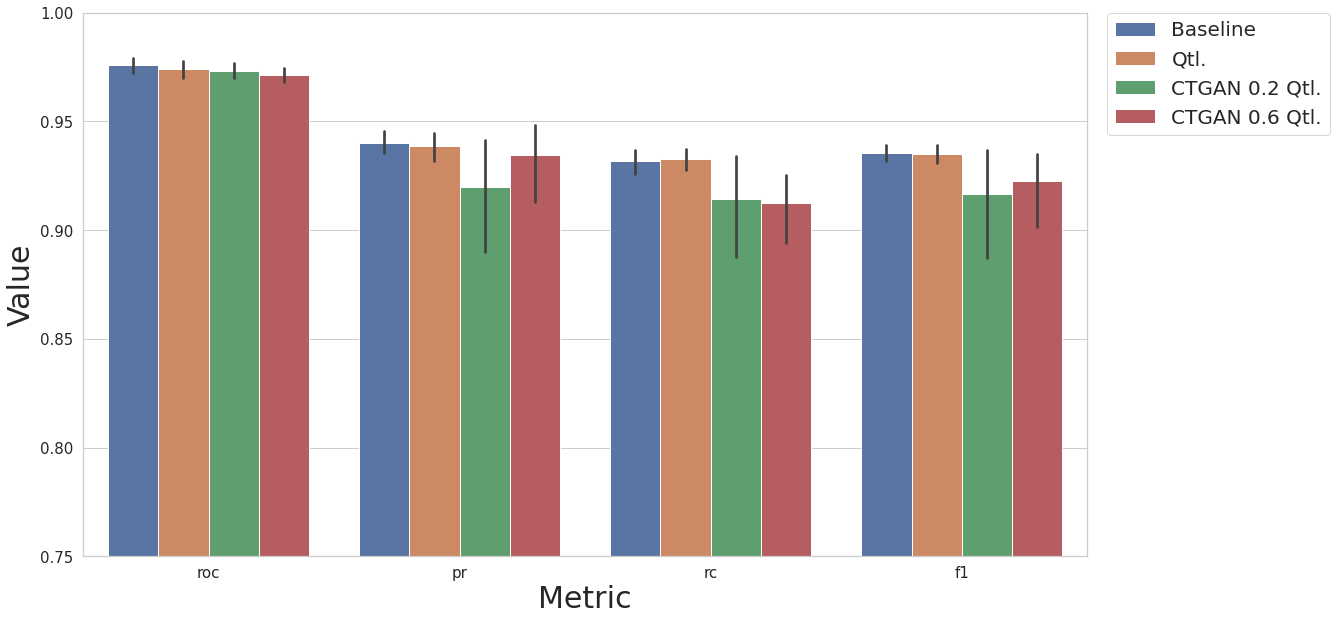

In [24]:
cs.plot_results(result_df, y_lim=[0.75, 1.0])